# Model with Multilayer Perceptron (MLP) Neural Network

For this model, we choose:

- hidden layer
- accuracy, AUC-ROC, and a confusion matrix as performance metrics

Epoch [1/50], Step [100/429], Loss: 2.8212
Epoch [1/50], Step [200/429], Loss: 2.1802
Epoch [1/50], Step [300/429], Loss: 2.0969
Epoch [1/50], Step [400/429], Loss: 1.6953
Epoch [2/50], Step [100/429], Loss: 1.6071
Epoch [2/50], Step [200/429], Loss: 1.3551
Epoch [2/50], Step [300/429], Loss: 1.5647
Epoch [2/50], Step [400/429], Loss: 1.3383
Epoch [3/50], Step [100/429], Loss: 1.1537
Epoch [3/50], Step [200/429], Loss: 0.9355
Epoch [3/50], Step [300/429], Loss: 1.0949
Epoch [3/50], Step [400/429], Loss: 1.0414
Epoch [4/50], Step [100/429], Loss: 1.1583
Epoch [4/50], Step [200/429], Loss: 0.6849
Epoch [4/50], Step [300/429], Loss: 1.0535
Epoch [4/50], Step [400/429], Loss: 0.9485
Epoch [5/50], Step [100/429], Loss: 1.0575
Epoch [5/50], Step [200/429], Loss: 0.7037
Epoch [5/50], Step [300/429], Loss: 0.7072
Epoch [5/50], Step [400/429], Loss: 0.9745
Epoch [6/50], Step [100/429], Loss: 0.8244
Epoch [6/50], Step [200/429], Loss: 0.7388
Epoch [6/50], Step [300/429], Loss: 0.6067
Epoch [6/50

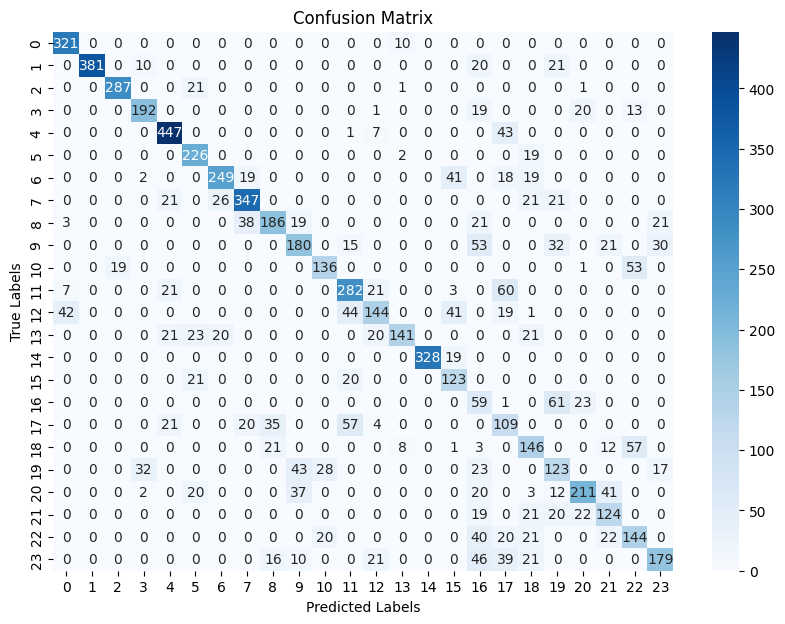

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def remap_labels(label):
    if label > 9:
        label -= 1  # Decrementation for J
    return label

class CustomDataset(Dataset):
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        self.X = torch.tensor(self.data.iloc[:, 1:].values, dtype=torch.float32) / 255.0
        self.y = torch.tensor(self.data.iloc[:, 0].values, dtype=torch.long)
        self.y = torch.tensor([remap_labels(label.item()) for label in self.y], dtype=torch.long)  # Remap labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = 784
hidden_size = 128
num_classes = 24
learning_rate = 0.001
batch_size = 64
epochs = 50

# Initialize dataset and dataloaders
train_dataset = CustomDataset('../../data/sign_mnist_train.csv')
test_dataset = CustomDataset('../../data/sign_mnist_test.csv')
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize model, loss, and optimizer
model = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

y_true = []
y_pred = []

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.tolist())
        all_preds.extend(F.softmax(outputs, dim=1).tolist())
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())
    
    accuracy = 100 * correct / total

print(f'Unique labels in y_true: {np.unique(all_labels)}')
print(f'Shape of y_score: {np.array(all_preds).shape}')

# Calculate AUC-ROC only if the shapes are expected
if len(np.unique(all_labels)) == np.array(all_preds).shape[1]:
    auc_roc = roc_auc_score(np.array(all_labels), np.array(all_preds), multi_class='ovr')
    print(f'AUC-ROC: {auc_roc}')
else:
    print("Mismatch in the number of classes and y_score columns, cannot compute AUC-ROC.")

print(f'Accuracy of the network on the test images: {accuracy} %')

# Calculating the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Show that matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

    


We can observe:
- good results!
- a very good AUC-ROC, which implies that our model effectively distinguishes between all classes.
- thanks to the confusion matrix, we can understand that the letter for 16 has a lot of false predictions compared to the others. We can also see that there is significant confusion between 16 and 19.